In [1]:
import os
import PIL
import cv2
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Ignore tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow.keras
import visualkeras

from torch import nn
from PIL import ImageFont
from scipy import stats as st
from datasets import load_dataset
from collections import defaultdict
from tensorflow.keras import Sequential
from IPython.display import clear_output
from tensorflow.keras import backend as K
from huggingface_hub import notebook_login
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split 
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, UpSampling2D, BatchNormalization

# Ignore warnings
from warnings import simplefilter
simplefilter(action='ignore')

# Set up tensorflow for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
# Load dataset
dataset = "segments/sidewalk-semantic"
ds = load_dataset(dataset)

images = ds['train']['pixel_values']
labels = ds['train']['label']

# Split the data
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=100)

# Free up memory space
ds, images, labels = [], [], []

Found cached dataset parquet (/home/james/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-007b1ee78ca1e890/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
scale = (240, 144)

x_train = np.asarray([cv2.resize(np.array(x), scale) for x in x_train], dtype=np.float32)
y_train = np.asarray([cv2.resize(np.array(y), scale) for y in y_train], dtype=np.float32)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray([cv2.resize(np.array(x), scale) for x in x_test])
y_test = np.asarray([cv2.resize(np.array(y), scale) for y in y_test])

In [4]:
# Switch to binary class matrices
y_train = to_categorical(y_train, 35)
y_test = to_categorical(y_test, 35)

In [5]:
kernel = [(3,3), (3,3), (3,3), (3,3), (3,3), (3,3), (3,3), (3,3)]
size = [16, 32, 64, 128]

# CNN model
model = Sequential()

# Encoding
model.add(Conv2D(size[0], kernel[0], activation='relu', padding='same', input_shape=np.shape(x_train[0])))
model.add(BatchNormalization())
model.add(Conv2D(size[0], kernel[0], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv2D(size[1], kernel[1], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[1], kernel[1], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[1], kernel[1], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(size[2], kernel[2], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[2], kernel[2], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[2], kernel[2], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(Conv2D(size[3], kernel[3], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[3], kernel[3], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[3], kernel[3], activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Decoding
model.add(UpSampling2D(size=(2,2), interpolation='nearest'))
model.add(Conv2D(size[3], kernel[4], padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[3], kernel[4], padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[3], kernel[4], padding='same'))
model.add(BatchNormalization())

model.add(UpSampling2D(size=(2,2), interpolation='nearest'))
model.add(Conv2D(size[3], kernel[5], padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[2], kernel[5], padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[2], kernel[5], padding='same'))
model.add(BatchNormalization())

model.add(UpSampling2D(size=(2,2), interpolation='nearest'))
model.add(Conv2D(size[2], kernel[6], padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[1], kernel[6], padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[1], kernel[6], padding='same'))
model.add(BatchNormalization())

model.add(UpSampling2D(size=(2,2), interpolation='nearest'))
model.add(Conv2D(size[1], kernel[7], padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(size[0], kernel[7], padding='same'))
model.add(BatchNormalization())

model.add(Dense(35, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

start = time.time()
model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=8, epochs=90, verbose=2)

score = model.evaluate(x_test, y_test, verbose=0)
elapsed = time.time() - start

print('\n')
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

h = int(elapsed / (60 * 60))
m = int((elapsed % (60 * 60)) / 60)
s = elapsed % 60

print("Elapsed time: {}:{:>02}:{:>05.2f}".format(h, m, s))

Epoch 1/90
100/100 - 85s - loss: 2.4344 - accuracy: 0.4756 - val_loss: 7.4078 - val_accuracy: 0.4630
Epoch 2/90
100/100 - 5s - loss: 1.7538 - accuracy: 0.5797 - val_loss: 2.8430 - val_accuracy: 0.5706
Epoch 3/90
100/100 - 4s - loss: 1.4946 - accuracy: 0.6148 - val_loss: 5.1961 - val_accuracy: 0.3698
Epoch 4/90
100/100 - 4s - loss: 1.3949 - accuracy: 0.6244 - val_loss: 5.1558 - val_accuracy: 0.3690
Epoch 5/90
100/100 - 5s - loss: 1.3013 - accuracy: 0.6475 - val_loss: 2.4536 - val_accuracy: 0.5291
Epoch 6/90
100/100 - 5s - loss: 1.2353 - accuracy: 0.6598 - val_loss: 2.9466 - val_accuracy: 0.3601
Epoch 7/90
100/100 - 5s - loss: 1.1566 - accuracy: 0.6814 - val_loss: 1.5840 - val_accuracy: 0.5979
Epoch 8/90
100/100 - 5s - loss: 1.1250 - accuracy: 0.6877 - val_loss: 1.9369 - val_accuracy: 0.5133
Epoch 9/90
100/100 - 5s - loss: 1.0838 - accuracy: 0.6984 - val_loss: 1.3689 - val_accuracy: 0.6205
Epoch 10/90
100/100 - 5s - loss: 1.0748 - accuracy: 0.6962 - val_loss: 1.4325 - val_accuracy: 0.674

Epoch 83/90
100/100 - 5s - loss: 0.2868 - accuracy: 0.9183 - val_loss: 1.2458 - val_accuracy: 0.7475
Epoch 84/90
100/100 - 5s - loss: 0.3245 - accuracy: 0.9067 - val_loss: 1.2154 - val_accuracy: 0.7567
Epoch 85/90
100/100 - 5s - loss: 0.2856 - accuracy: 0.9186 - val_loss: 1.2028 - val_accuracy: 0.7550
Epoch 86/90
100/100 - 5s - loss: 0.3225 - accuracy: 0.9075 - val_loss: 1.4116 - val_accuracy: 0.7399
Epoch 87/90
100/100 - 5s - loss: 0.3176 - accuracy: 0.9086 - val_loss: 1.1922 - val_accuracy: 0.7562
Epoch 88/90
100/100 - 5s - loss: 0.2732 - accuracy: 0.9217 - val_loss: 1.1427 - val_accuracy: 0.7661
Epoch 89/90
100/100 - 5s - loss: 0.2656 - accuracy: 0.9246 - val_loss: 1.1337 - val_accuracy: 0.7651
Epoch 90/90
100/100 - 5s - loss: 0.2623 - accuracy: 0.9256 - val_loss: 1.1617 - val_accuracy: 0.7621


Test loss: 1.1617140769958496
Test accuracy: 0.762130081653595
Elapsed time: 0:08:52.60


In [6]:
# Find label for each pixel of predictions
y_pred = []
pred = model.predict(x_test)

for i in range(len(pred)):
    for j in range(len(pred[0])):
        for k in range(len(pred[0][0])):
            y_pred.append(np.argmax(pred[i][j][k]))
    
    clear_output(wait=True)
    print("Image: {}".format(i + 1))

y_pred = np.array(y_pred).reshape((200,144,240))

Image: 200


In [7]:
# Find label for each pixel of ground truth
y_true = []

for i in range(len(y_test)):
    for j in range(len(y_test[0])):
        for k in range(len(y_test[0][0])):
            y_true.append(np.argmax(y_test[i][j][k]))
            
    clear_output(wait=True)
    print("Image: {}".format(i + 1))

y_test = np.array(y_true).reshape((200,144,240))

Image: 200


In [8]:
label = ["unlabeled", "road", "sidewalk", "crosswalk", "cycling lane", 
         "parking", "railroad", "curb", "person", "rider", "car", "truck",
         "bus", "train", "motorcycle", "bicycle", "camper", "trailer",
         "building", "door", "wall", "barrier", "bridge", "tunnel",
         "stairs", "pole", "traffic sign", "traffic light", "vegetation",
         "terrain", "sky", "ground", "dynamic", "static", "unclear"]

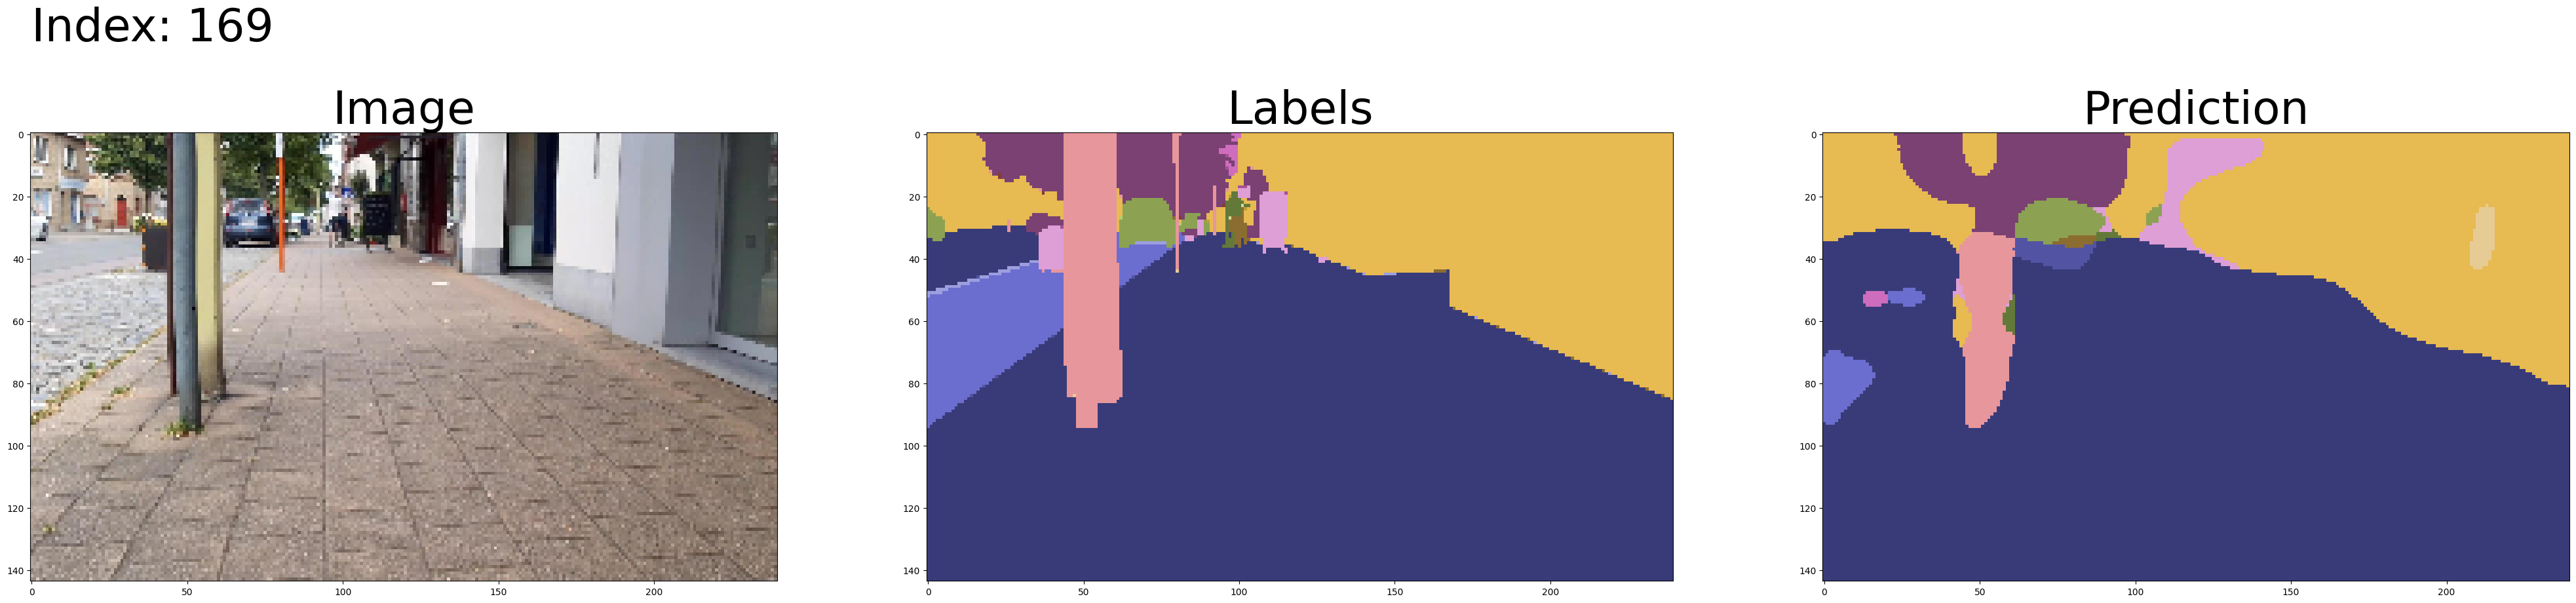

In [9]:
# Display prediction
f, axs = plt.subplots(1, 3, figsize=(30, 10))
f.set_figheight(30)
f.set_figwidth(50)

# Set color map for images
cmap = plt.get_cmap("tab20b", 35)
plt.set_cmap(cmap)

# Pick random picture 
n = random.randint(0, len(y_test) - 1)

axs[0].text(0, -30, ("Index: "+ str(n)), fontsize=50)
axs[0].set_title("Image", {'fontsize': 50})
axs[0].imshow(x_test[n])

axs[1].set_title("Labels", {'fontsize': 50})
axs[1].imshow(y_test[n])

axs[2].set_title("Prediction", {'fontsize': 50})
axs[2].imshow(y_pred[n])

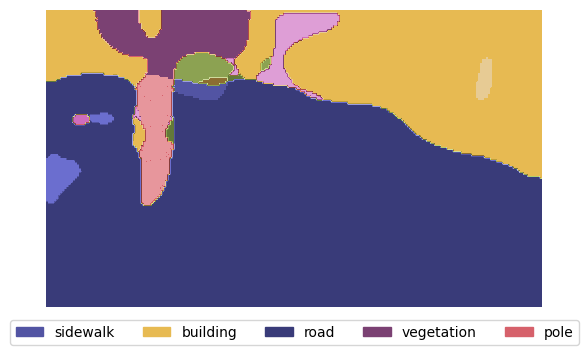

In [10]:
# Display prediction with labels
y_pred_flat = y_pred[n].flatten()

# Sort to top labels
elements, frequency = np.unique(y_pred_flat, return_counts=True)
si = np.argsort(frequency)[::-1]
sbf = elements[si]

plt.imshow(y_pred[n])
plt.axis('off')

label1 = patches.Patch(color=cmap(sbf[0]), label=label[sbf[0]])
label2 = patches.Patch(color=cmap(sbf[1]), label=label[sbf[1]])
label3 = patches.Patch(color=cmap(sbf[2]), label=label[sbf[2]])
label4 = patches.Patch(color=cmap(sbf[3]), label=label[sbf[3]])
label5 = patches.Patch(color=cmap(sbf[4]), label=label[sbf[4]])

handles = [label1, label2, label3, label4, label5]

plt.legend(handles=handles, loc='lower center', ncol=len(handles), bbox_to_anchor=(0.5, -0.15))
plt.show()

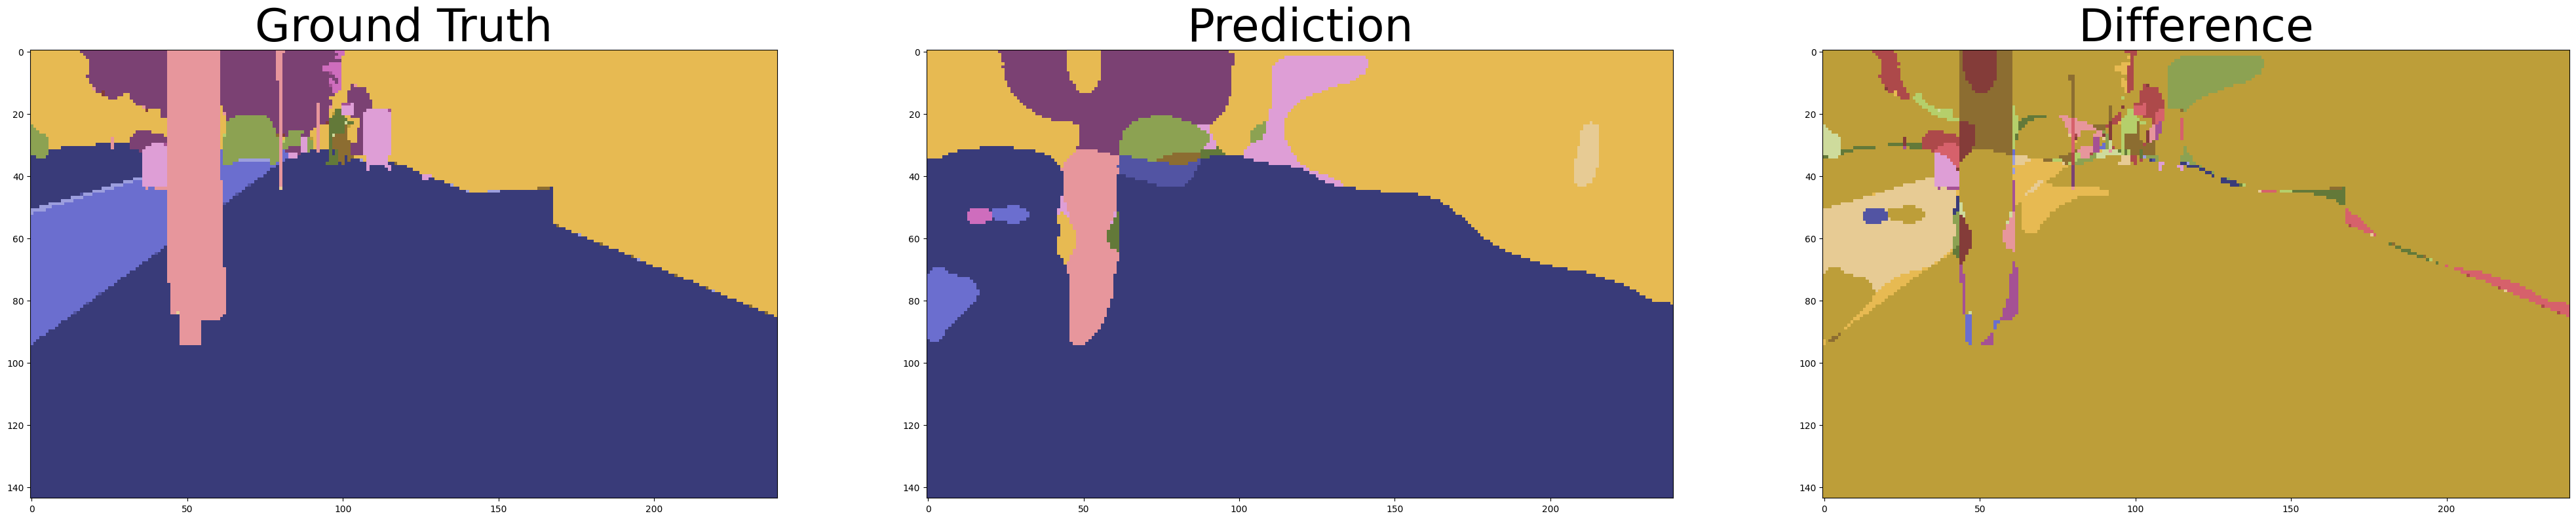

In [11]:
# Display differences between ground truth and predicition
diff = np.subtract(y_test[n], y_pred[n])

f, axs = plt.subplots(1, 3, figsize=(30, 10))
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Ground Truth", {'fontsize': 50})
axs[0].imshow(y_test[n])

axs[1].set_title("Prediction", {'fontsize': 50})
axs[1].imshow(y_pred[n])

axs[2].set_title("Difference", {'fontsize': 50})
axs[2].imshow(diff)

In [12]:
#visualkeras.layered_view(model)
#visualkeras.layered_view(model, scale_xy=1, scale_z=1, max_z=1000)

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'blue'
#color_map[ZeroPadding2D]['fill'] = 'gray'
#color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'green'
color_map[Dense]['fill'] = 'yellow'
color_map[UpSampling2D]['fill'] = 'red'
color_map[BatchNormalization]['fill'] = 'orange'
#color_map[Flatten]['fill'] = 'teal'

font = ImageFont.truetype("calibri.ttf", 32)  # using comic sans is strictly prohibited!
visualkeras.layered_view(model, legend=True, font=font, scale_xy=3, scale_z=1, max_z=30, color_map=color_map, to_file='Architecture.png')  # font is optional!

#visualkeras.layered_view(model, to_file='Architecture.png')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 144, 240, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 144, 240, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 240, 16)      2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 144, 240, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 120, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 120, 32)       4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 120, 32)       1